In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
df = pd.read_csv('../data/train.csv')
df = df.dropna(subset=['comment_text'])
df['toxic_label'] = (df['target'] > 0.5).astype(int)

### Character count in each sentence

In [10]:
df['character_lengths'] = df['comment_text'].apply(len)

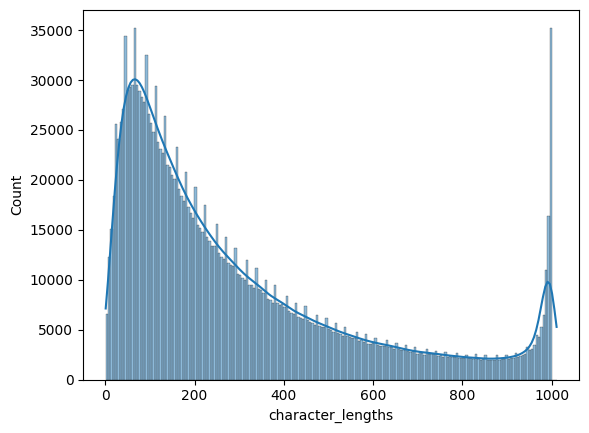

In [11]:
lengths = df.loc[df['character_lengths']<1125]['character_lengths']
sns.histplot(lengths, kde=True)
plt.show()

### Word count in each sentence

In [12]:
df['word_lengths'] = df['comment_text'].apply(lambda x: len(x) - len(''.join(x.split())) + 1)

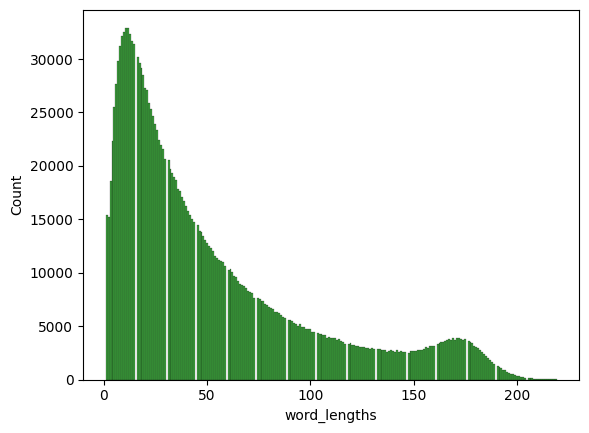

In [15]:
words = df.loc[df['word_lengths']<220]['word_lengths']
sns.histplot(words, color='g')
plt.show()

### Toxicity comment count

C:\Users\shrav\AppData\Local\Temp\ipykernel_6084\559579392.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='toxicity_bin', palette='Set3', order=labels)


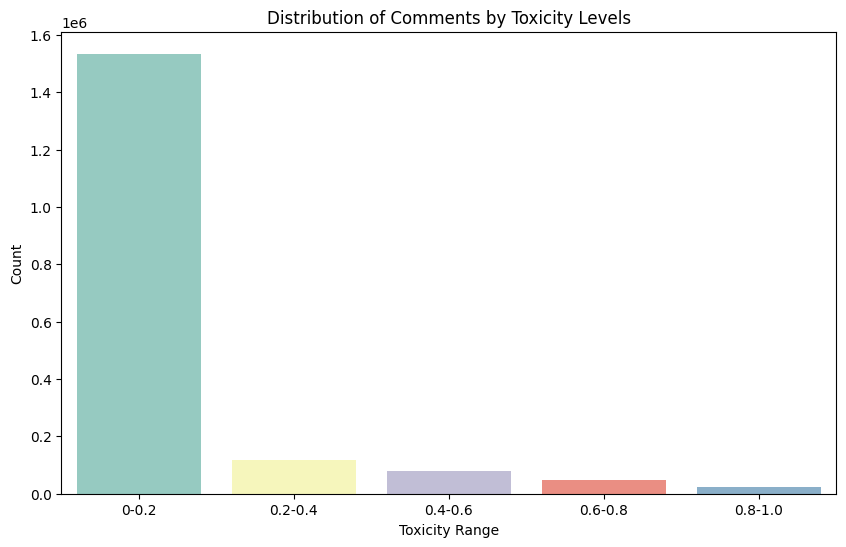

In [ ]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']

df['toxicity_bin'] = pd.cut(df['target'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='toxicity_bin', palette='Set3', order=labels)
plt.xlabel("Toxicity Range")
plt.ylabel("Count")
plt.title("Distribution of Comments by Toxicity Levels")
plt.show()

### Toxic comments timing

In [ ]:
df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')

In [27]:
df['is_toxic'] = df['target'] > 0.5

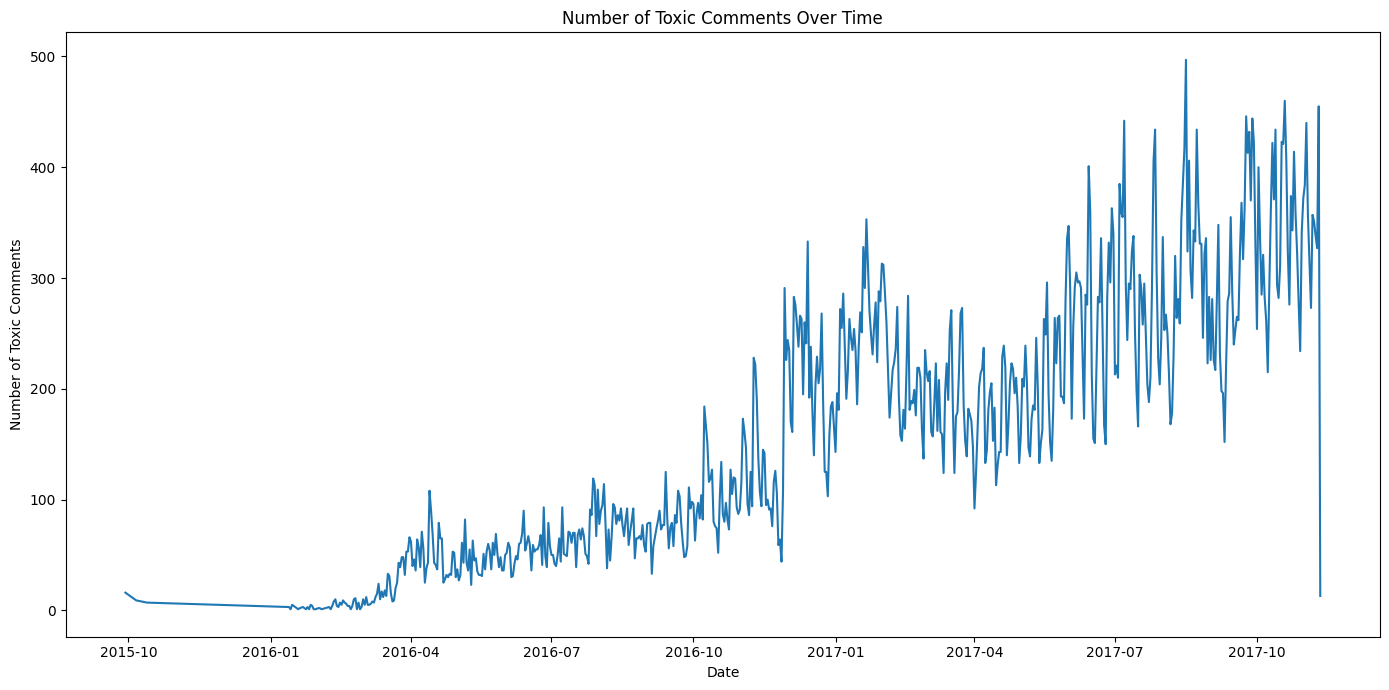

In [ ]:
toxic_comments_per_day = (
    df[df['is_toxic']]
    .groupby(df['created_date'].dt.date)
    .size()
    .reset_index(name='toxic_comment_count')
)

# Plotting the toxic comments over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=toxic_comments_per_day, x='created_date', y='toxic_comment_count')
plt.xlabel("Date")
plt.ylabel("Number of Toxic Comments")
plt.title("Number of Toxic Comments Over Time")
plt.tight_layout()
plt.show()

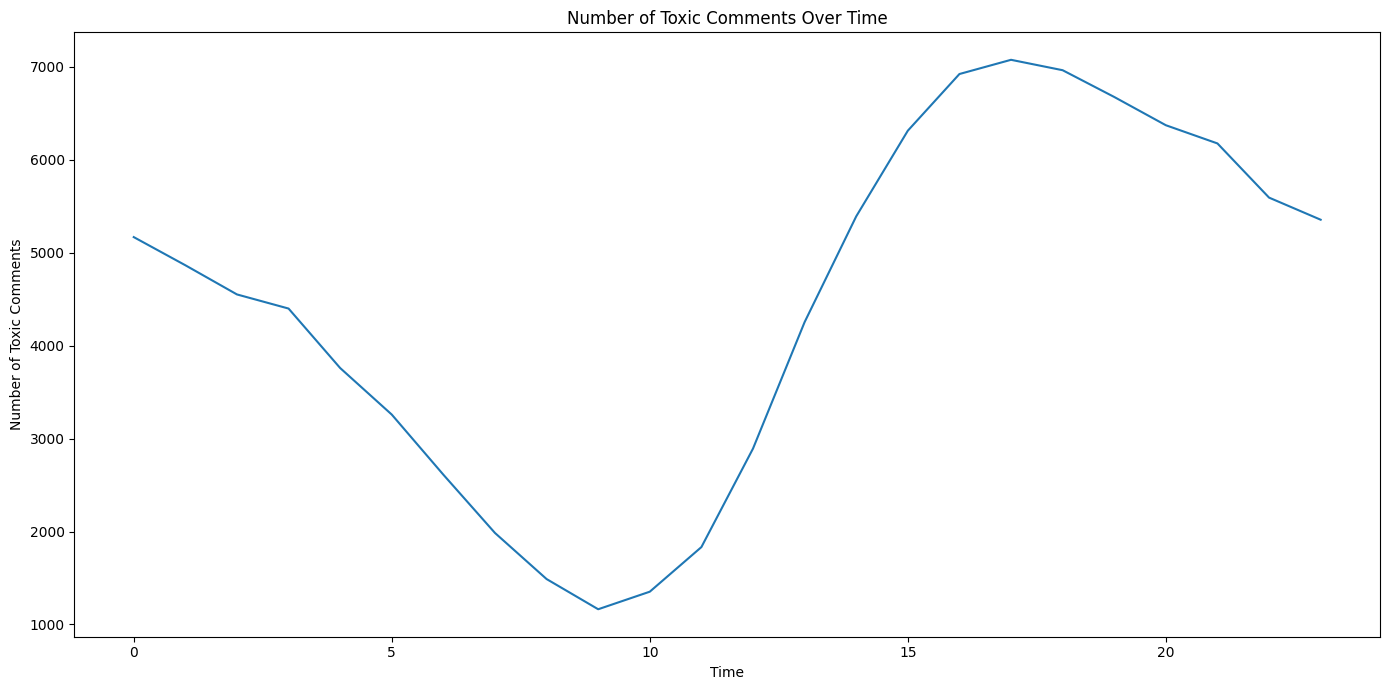

In [35]:
toxic_comments_per_hour = (
    df[df['is_toxic']]
    .groupby(df['created_date'].dt.hour)
    .size()
    .reset_index(name='toxic_comment_count')
)

# Plotting the toxic comments over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=toxic_comments_per_hour, x='created_date', y='toxic_comment_count')
plt.xlabel("Time")
plt.ylabel("Number of Toxic Comments")
plt.title("Number of Toxic Comments Over Time")
plt.tight_layout()
plt.show()

People should stop posting once its dark out

### Toxicity against identities

C:\Users\shrav\AppData\Local\Temp\ipykernel_6084\1749835836.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=identity_toxicity, x='identity', y='target', palette='viridis')


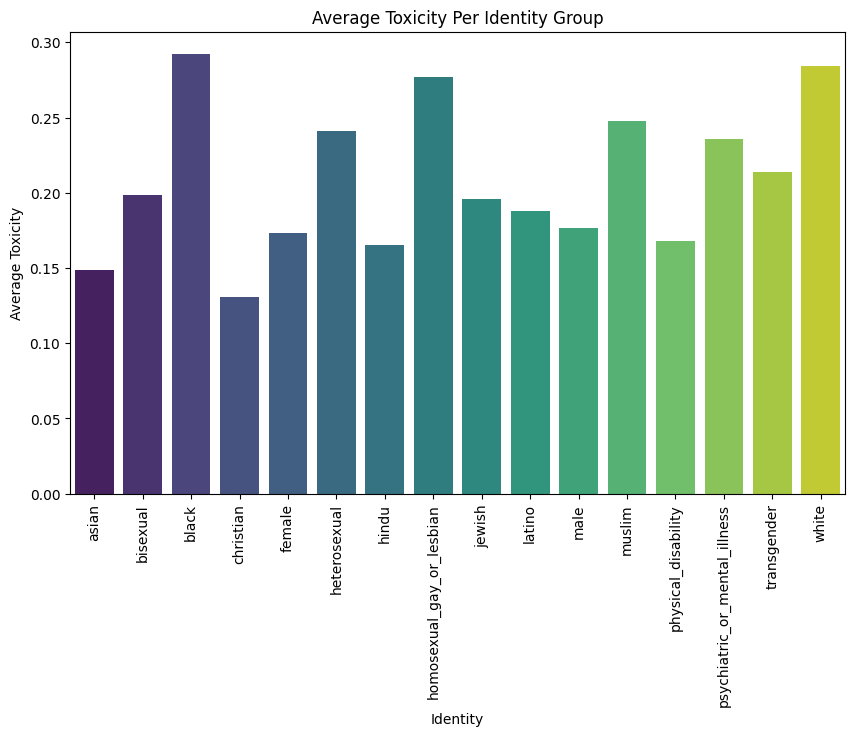

In [44]:
identity_columns = ['male','female','transgender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','christian','jewish','muslim','hindu',
              'black','white','asian','latino',
              'physical_disability','psychiatric_or_mental_illness']
toxicity_per_identity = df[identity_columns + ['target']].melt(id_vars=['target'], 
                                                               var_name='identity', 
                                                               value_name='is_present')

toxicity_per_identity = toxicity_per_identity[toxicity_per_identity['is_present'] > 0]
identity_toxicity = toxicity_per_identity.groupby('identity')['target'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=identity_toxicity, x='identity', y='target', palette='viridis')
plt.xlabel("Identity")
plt.ylabel("Average Toxicity")
plt.title("Average Toxicity Per Identity Group")
plt.xticks(rotation=90)
plt.show()


### Comment toxicity distribution for identities

In [49]:
df['has_identity'] = df[identity_columns].sum(axis=1) > 0.2
df['is_toxic'] = df['target'] > 0.5

identity_non_toxic = df[(df['has_identity']) & (~df['is_toxic'])]
identity_toxic_counts = df[df['has_identity']].groupby('is_toxic')[identity_columns].sum().T
identity_toxic_counts.columns = ['Non-Toxic', 'Toxic']

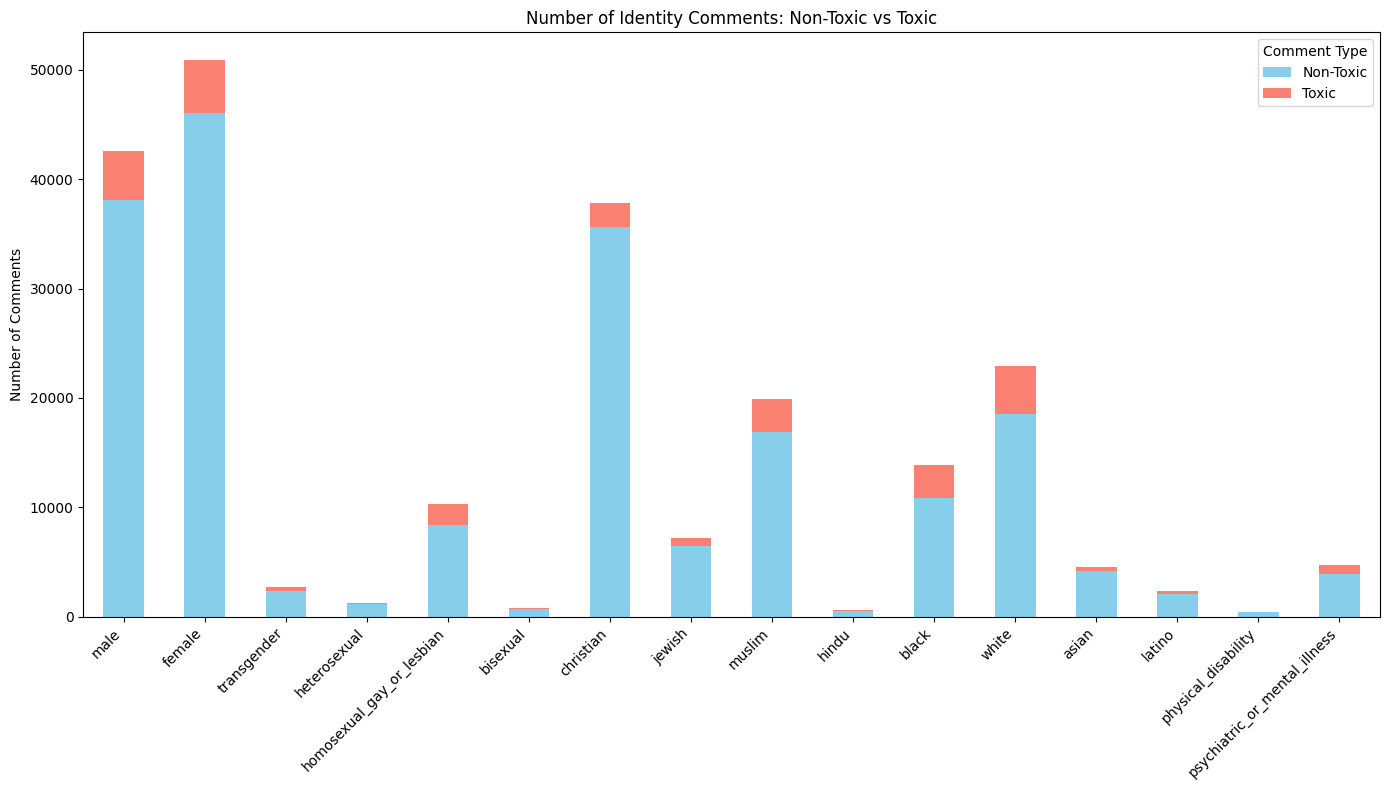

In [50]:
identity_toxic_counts.plot(kind='bar', stacked=True, figsize=(14, 8), color=['skyblue', 'salmon'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Comments")
plt.title("Number of Identity Comments: Non-Toxic vs Toxic")
plt.legend(title='Comment Type')
plt.tight_layout()
plt.show()

In [ ]:
df['toxicity_bin'] = pd.cut(df['target'], bins=[0, 0.2, 0.5, 0.8, 1.0], labels=['Low', 'Medium', 'High', 'Severe'])

identity_toxicity = df.melt(
    id_vars=['toxicity_bin'], 
    value_vars=identity_columns, 
    var_name='Identity', 
    value_name='Present'
)
identity_toxicity = identity_toxicity[identity_toxicity['Present'] > 0]

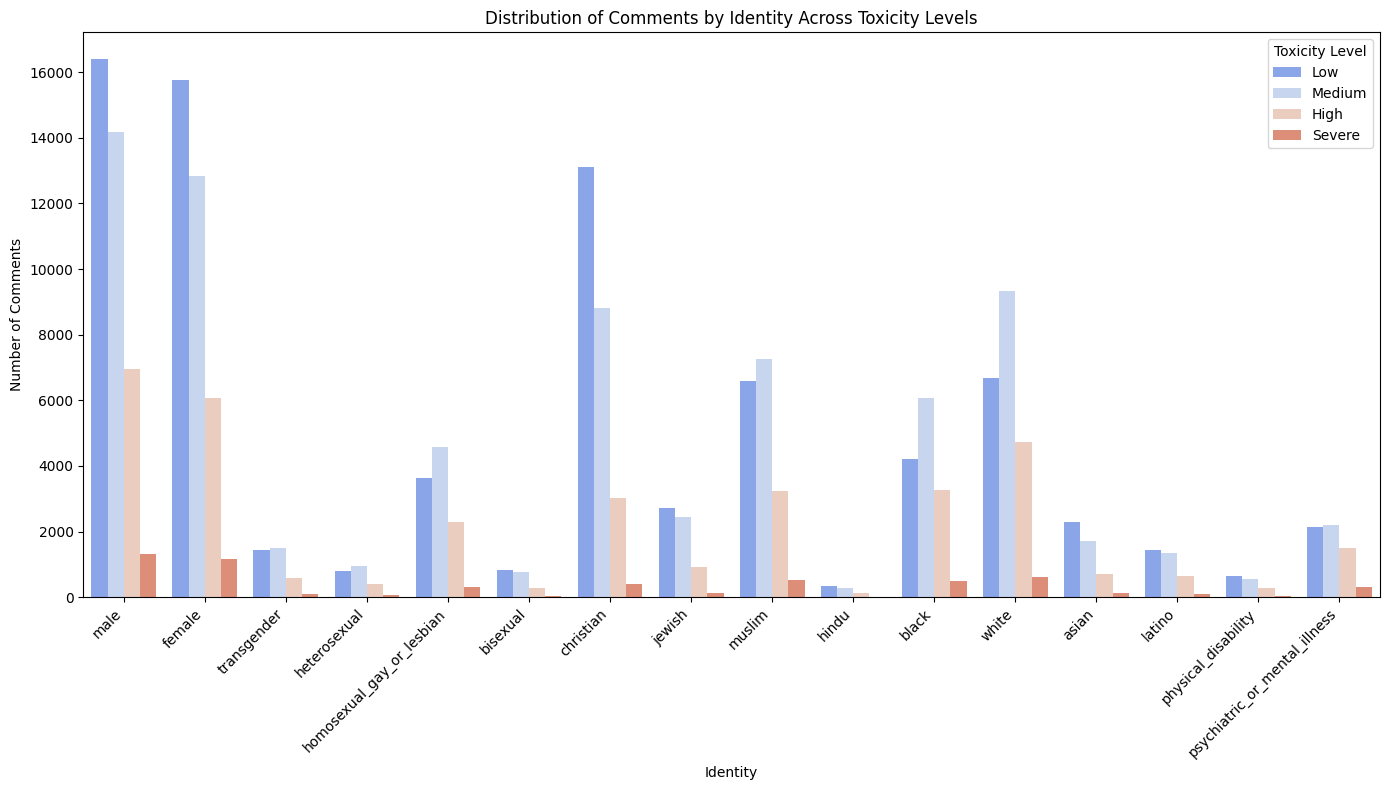

In [ ]:
plt.figure(figsize=(14, 8))
sns.countplot(data=identity_toxicity, x='Identity', hue='toxicity_bin', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Comments")
plt.title("Distribution of Comments by Identity Across Toxicity Levels")
plt.legend(title='Toxicity Level')
plt.tight_layout()
plt.show()

### Wordclouds for toxic and non-toxic comments

In [ ]:
# Filter for severely toxic comments
severe_toxic_comments = ' '.join(df[df['target'] > 0.8]['comment_text'].fillna(''))
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(severe_toxic_comments)

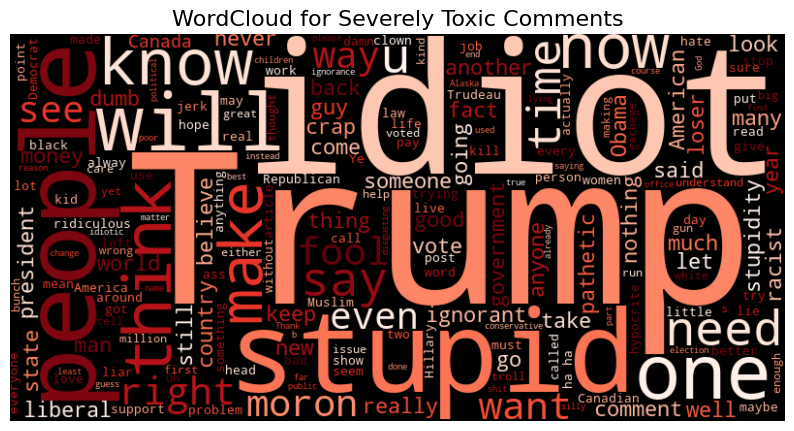

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Severely Toxic Comments", fontsize=16)
plt.show()

In [ ]:
non_toxic_comments = ' '.join(df[df['target'] < 0.2]['comment_text'].fillna(''))
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Greens').generate(non_toxic_comments)

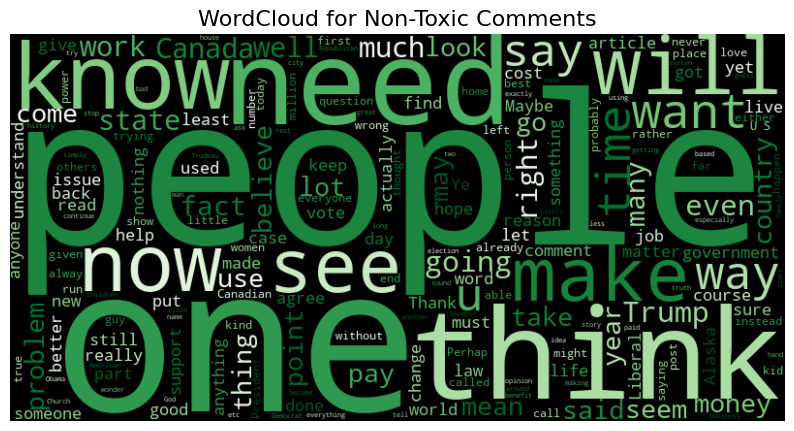

In [53]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Non-Toxic Comments", fontsize=16)
plt.show()

### Frequency of most common toxic words

C:\Users\shrav\AppData\Local\Temp\ipykernel_6084\1630490747.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=freq_df, x='Word', y='Count', palette='viridis')


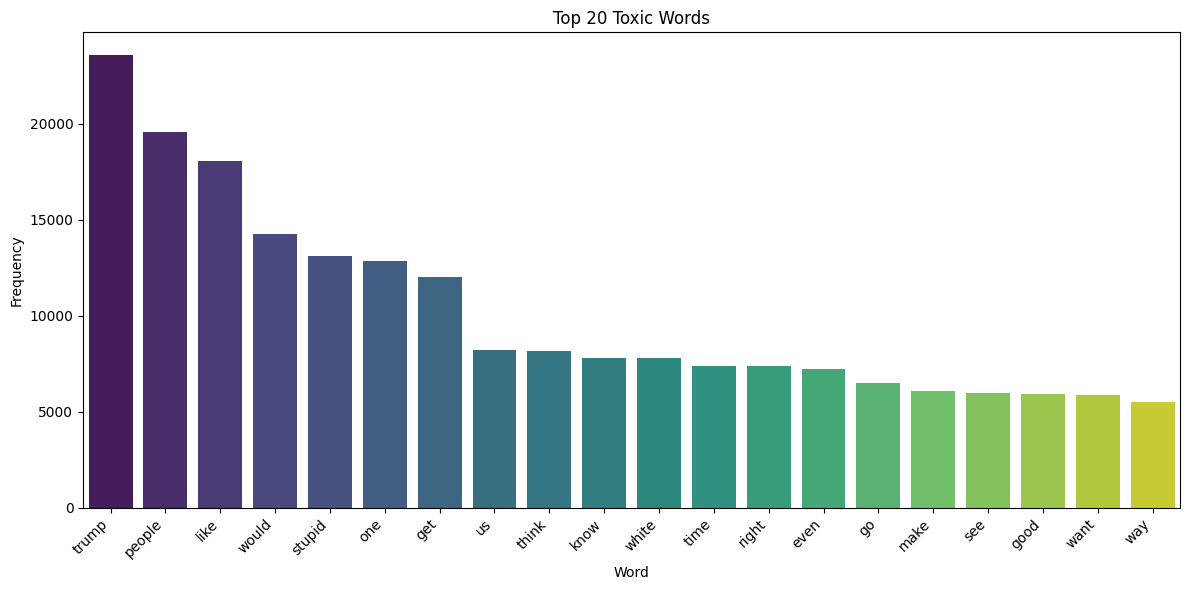

In [54]:
from collections import Counter
from nltk.tokenize import word_tokenize

# Tokenize toxic comments and count word frequency
toxic_comments = df[df['target'] > 0.5]['comment_text'].fillna('')
toxic_tokens = ' '.join(toxic_comments).lower()
toxic_tokens = word_tokenize(toxic_tokens)

# Remove stopwords (optional: use NLTK stopwords list)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [token for token in toxic_tokens if token.isalpha() and token not in stop_words]

# Get most common words
top_toxic_words = Counter(filtered_tokens).most_common(20)

# Convert to DataFrame for plotting
words, counts = zip(*top_toxic_words)
freq_df = pd.DataFrame({'Word': words, 'Count': counts})

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=freq_df, x='Word', y='Count', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Frequency")
plt.title("Top 20 Toxic Words")
plt.tight_layout()
plt.show()